In [1]:
import logging
from pathlib import Path
import click
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import numpy as np

In [2]:
def read_fen(fen: str):
    board = []
    for char in fen:
        if(char.isdigit()):
            board += [np.nan] * int(char)
        elif(char != '-'):
            board += char
    board = np.reshape(board, (8, 8))
    return board

In [3]:
def load_data(path: Path):
    X = []
    y = []
    for x in path.glob("*.npy"):
        X.append(np.load(x))
        y.append(read_fen(x.stem))

    X = np.array(X)
    X = np.moveaxis(X, 0, -1)
    X = X.T.reshape(
        (
            X.shape[-1] * 8 * 8,  # number of squares
            50 * 50,  # pixels per square
        )
    )

    y = np.array(y).flatten()

    return X, y

In [4]:
path = Path('../../data/processed')
# LOAD DATA
tr_X, tr_y = load_data(path.joinpath('train'))

pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=60)),
    ("logistic", LogisticRegression())
])

params = {
"logistic__solver" : ['saga'],
"logistic__penalty" : ['l2', 'l1'],
"logistic__C" : [0.01, 0.1, 1, 10],
"logistic__class_weight" : [None, 'balanced']
}

gscv = GridSearchCV(pipeline, cv=3, scoring='accuracy',param_grid=params, verbose=3)
gscv.fit(tr_X, tr_y)

test_X, test_y = load_data(path.joinpath('test'))
score = gscv.score(test_X, test_y)
print(score)
print(gscv.best_params_)
print(gscv.cv_results_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END logistic__C=0.01, logistic__class_weight=balanced, logistic__penalty=l2, logistic__solver=saga;, score=0.034 total time=  54.3s
[CV 2/3] END logistic__C=0.01, logistic__class_weight=balanced, logistic__penalty=l2, logistic__solver=saga;, score=0.033 total time=  56.4s
[CV 3/3] END logistic__C=0.01, logistic__class_weight=balanced, logistic__penalty=l2, logistic__solver=saga;, score=0.029 total time=  50.0s
[CV 1/3] END logistic__C=0.1, logistic__class_weight=balanced, logistic__penalty=l2, logistic__solver=saga;, score=0.033 total time= 1.0min
[CV 2/3] END logistic__C=0.1, logistic__class_weight=balanced, logistic__penalty=l2, logistic__solver=saga;, score=0.032 total time= 1.6min
[CV 3/3] END logistic__C=0.1, logistic__class_weight=balanced, logistic__penalty=l2, logistic__solver=saga;, score=0.029 total time= 1.7min
[CV 1/3] END logistic__C=1, logistic__class_weight=balanced, logistic__penalty=l2, logistic__solv

In [ ]:
unique, counts = np.unique(tr_y, return_counts=True)
print(unique, counts)

['B' 'K' 'N' 'P' 'Q' 'R' 'b' 'k' 'n' 'nan' 'p' 'q' 'r'] [  3404   2500   2223   2312   1139   2179   3416   2500   2276 132405
   2321   1122   2203]


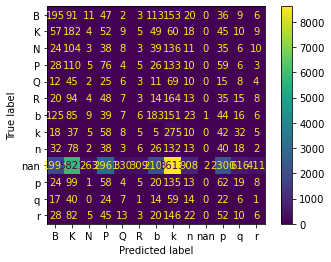

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gscv, test_X, test_y)
plt.savefig("./logistic.png")